In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dataclasses import dataclass

In [3]:

attributions = pd.read_csv('data/eurepoc_attribution_dataset_1.3.csv')

attributions.head()

,attribution_id,incident_id,attribution_year,attribution_month,attribution_day,attribution_date,attribution_basis,attribution_type,attribution_subtype,attributing_country,attributing_actor,attributing_company,settled_attribution,initiator_name,initiator_alpha_2,initiator_country,initiator_category,initiator_subcategory
0,6,6,NaN,NaN,NaN,Not available,Attacker confirms,Self-attribution in the course of the attack (...,Not available,Not available,Not available,Not available,True,Unknown,US,United States,Non-state-group,Hacktivist(s)
1,7,7,NaN,NaN,NaN,Not available,Attacker confirms,Self-attribution in the course of the attack (...,Not available,Not available,Not available,Not available,True,Antijapan,KR,"Korea, Republic of",Non-state-group,Hacktivist(s)
2,10,10,2013.0,NaN,NaN,2013,Attribution by third-party,"Direct statement in media report (e.g., Reuter...",Not available,Not available,Not available,Not available,True,NSA/Equation Group,US,United States,State,Not available
3,11,11,2005.0,NaN,NaN,2005,Attribution by receiver government / state entity,"Anonymous statement in media report (e.g., Reu...",Not available,Not available,Not available,Not available,True,Unknown,CN,China,State affiliated actor,Not available
4,12,11,2005.0,NaN,NaN,2005,IT-security community attributes attacker,"Technical report (e.g., by IT-companies, Citiz...",Not available,Not available,Not available,Not available,NaN,Unknown,CN,China,State affiliated actor,Not available


In [4]:
# Get unique "initiator_name" values sorted by the number of occurrences
print(attributions['initiator_name'].value_counts().head(10))

initiator_name
Unknown                                                                                                                                                                                                                                          1275
Not attributed                                                                                                                                                                                                                                    912
Anonymous                                                                                                                                                                                                                                         211
Lazarus Group/Labyrinth Chollima/HIDDEN COBRA/Guardians of Peace/Diamond Sleet fka ZINC/NICKEL ACADEMY/NewRomanic Cyber Army Team/Whois Hacking Team/Appleworm/Group 77/G0032 (Reconnaissance General Bureau, Bureau 121, Unit 180, Lab 110)      101
F

In [5]:
# Filter out rows with missing values in the 'initiator_name' column
# Or where 'initiator_name' is "Unknown" or "Not attributed"
filtered_attributions = attributions[
    attributions['initiator_name'].notna() &
    (attributions['initiator_name'] != "Unknown") &
    (attributions['initiator_name'] != "Not attributed") &
    attributions["settled_attribution"].notna() &
    (attributions["settled_attribution"])
]


incidents = filtered_attributions.groupby('incident_id')

connections = {}

for incident_id, group_data in incidents:
    actors = group_data["initiator_name"].unique()
    
    if len(actors) > 1:
        for i in range(len(actors)):
            for j in range(i + 1, len(actors)):
                actor1 = actors[i]
                actor2 = actors[j]
                
                edge = tuple(sorted([actor1, actor2]))
                if edge in connections:
                    connections[edge] += 1
                else:
                    connections[edge] = 1

incident_counts = filtered_attributions.groupby("initiator_name")["incident_id"].nunique()
incident_counts = incident_counts.reset_index()


In [6]:
# Make two separate dataframes for state-affiliated/states and non-state actors
state_actors = filtered_attributions[
    (filtered_attributions['initiator_category'] == "State affiliated actor") | 
    (filtered_attributions['initiator_category'] == "State")
]

non_state_actors = filtered_attributions[
    ((filtered_attributions['initiator_category'] == "Non-state-group") | 
    (~filtered_attributions['initiator_category'].str.lower().str.contains("state", na=False))) &
    ((filtered_attributions['initiator_category'] != "Unknown") &
    (filtered_attributions['initiator_category'] != "Other"))
]


In [7]:
# Check why state_actors contains non-state actors
# Check the unique values in the 'initiator_category' column
print(state_actors['initiator_category'].unique())
print(non_state_actors['initiator_category'].unique())

['State' 'State affiliated actor']
['Non-state-group' 'Individual hacker(s)']


In [8]:
@dataclass
class ActorNetwork:
    name: str
    network: nx.Graph
    sparse_network: nx.Graph
    data: pd.DataFrame
    incident_counts: pd.DataFrame
    
    @property
    def n_nodes(self) -> int:
        """The number of nodes in the network."""
        return self.network.number_of_nodes()
    
    @property
    def n_edges(self) -> int:
        """The number of edges in the network."""
        return self.network.number_of_edges()
    
    @property
    def density(self) -> float:
        """The density of the network."""
        return nx.density(self.network)
    
    @property
    def n_components(self) -> int:
        """The number of connected components in the network."""
        return nx.number_connected_components(self.network)
    
    @property
    def n_dyads(self) -> int:
        """The number of components with only 2 nodes."""
        return len([c for c in nx.connected_components(self.network) if len(c) == 2])
    
    @property
    def fraq_dyads(self) -> float:
        """The fraction of dyads in the network."""
        return self.n_dyads / self.n_components if self.n_components > 0 else 0
    
    @property
    def n_large_components(self) -> int:
        """The number of components with more than 2 nodes."""
        return len([c for c in nx.connected_components(self.network) if len(c) > 2])
    
    @property
    def component_sizes(self) -> tuple[int, ...]:
        """The sizes of the components in the network."""
        components = list(nx.connected_components(self.network))
        component_sizes = [len(component) for component in components]
        return tuple(component_sizes)
        
    @property
    def freeman_centralization_per_component(self) -> tuple[int, ...]:
        """The Freeman centralization for each component in the network."""
        components = list(nx.connected_components(self.network))
        component_centralities = []
        
        for i, component in enumerate(components):
            subgraph = self.network.subgraph(component).copy()
            
            if len(subgraph) < 3:
                continue
            
            centralization = nx.degree_centrality(subgraph)
            max_centrality = max(centralization.values())
            sum_deviation = sum(max_centrality - centrality for centrality in centralization.values())
            max_possible_centrality = (len(component) - 1) * (len(component) - 2)
            freeman_centrality = sum_deviation / max_possible_centrality if max_possible_centrality > 0 else 0            
            
            component_centralities.append(freeman_centrality)
            
        return tuple(component_centralities)
    
    @property
    def mean_freeman_centralization(self) -> float:
        """The mean Freeman centralization of the network."""
        return float(np.mean(self.freeman_centralization_per_component) if self.n_components > 0 else 0)    
    
    @property
    def transitivity_per_component(self) -> tuple[float, ...]:
        """The transitivity for each component in the network."""
        components = list(nx.connected_components(self.network))
        component_transitivities = []
        
        for i, component in enumerate(components):
            subgraph = self.network.subgraph(component).copy()
            
            if len(subgraph) < 3:
                continue
            
            component_transitivities.append(nx.transitivity(subgraph))
            
        return tuple(component_transitivities)
    
    @property
    def mean_transitivity(self) -> float:
        """The mean transitivity of the network."""
        return float(np.mean(self.transitivity_per_component))
    
    @property
    def global_clustering(self) -> float:
        """The global clustering coefficient of the network."""
        return nx.transitivity(self.network)    
        
    @property
    def n_isolated_actors(self) -> int:
        """The number of isolated actors *in the network*."""
        return len(list(nx.isolates(self.sparse_network)))
    
    @property
    def fraq_isolated_actors(self) -> float:
        """The fraction of isolated actors *in the network*."""
        total_actors = self.sparse_network.number_of_nodes()
        return self.n_isolated_actors / total_actors if total_actors > 0 else 0

In [9]:
# Function to create network graph from a filtered dataframe
def create_actor_network(filtered_df, name):

    # Group by incident_id
    incidents = filtered_df.groupby('incident_id')
    
    # Create connections dictionary
    connections = {}
    for incident_id, group_data in incidents:
        actors = group_data["initiator_name"].unique()
        
        if len(actors) > 1:
            for i in range(len(actors)):
                for j in range(i + 1, len(actors)):
                    actor1 = actors[i]
                    actor2 = actors[j]
                    
                    edge = tuple(sorted([actor1, actor2]))
                    if edge in connections:
                        connections[edge] += 1
                    else:
                        connections[edge] = 1
    
    # Create graph
    G = nx.Graph()
    for (actor1, actor2), weight in connections.items():
        G.add_edge(actor1, actor2, weight=weight)
    
    G_sparse = G.copy()
    # Add all unique actors as nodes (to include isolated nodes)
    all_actors = filtered_df["initiator_name"].unique()
    for actor in all_actors:
        if actor not in G.nodes:
            G_sparse.add_node(actor)
    
    # Count incidents per actor
    incident_counts = filtered_df.groupby("initiator_name")["incident_id"].nunique().reset_index()
    
    return ActorNetwork(name=name, network=G, sparse_network=G_sparse, data=filtered_df, incident_counts=incident_counts)
    

In [10]:
def component_grid_layout(G, components):
    """Arrange components in a grid to minimize whitespace."""
    pos = {}
    
    # Calculate grid dimensions
    n_components = len(components)
    cols = int(np.ceil(np.sqrt(n_components)))
    rows = int(np.ceil(n_components / cols))
    
    component_spacing = 3.0
    
    for idx, component in enumerate(components):
        row = idx // cols
        col = idx % cols
        
        # Center position for this component
        center_x = col * component_spacing
        center_y = -row * component_spacing  # Negative for top-to-bottom
        
        # Create subgraph and layout
        subgraph = G.subgraph(component)
        if len(component) == 1:
            # Single node
            node = list(component)[0]
            pos[node] = (center_x, center_y)
        elif len(component) == 2:
            # Dyad - place horizontally
            nodes = list(component)
            pos[nodes[0]] = (center_x - 0.3, center_y)
            pos[nodes[1]] = (center_x + 0.3, center_y)
        else:
            # Larger component - use spring layout within smaller space
            sub_pos = nx.spring_layout(subgraph, k=0.5, iterations=50, scale=0.8)
            for node in component:
                pos[node] = (sub_pos[node][0] + center_x, sub_pos[node][1] + center_y)
    
    return pos

In [11]:
def plot_actor_network(actor_network, color_by=None, enable_labels=True):
    title = actor_network.name
    # G = actor_network.sparse_network
    G = actor_network.network
    incident_counts = actor_network.incident_counts
    filtered_attributions = actor_network.data
    
    # Size nodes by incident count
    max_size = 500
    for node in G.nodes():
        try:
            node_size = incident_counts[incident_counts["initiator_name"] == node]["incident_id"].values[0]
            G.nodes[node]['size'] = 30 * np.sqrt(node_size)  # Square root scaling
            G.nodes[node]['size'] = min(G.nodes[node]['size'], max_size)
        except IndexError:
            G.nodes[node]['size'] = 30  # Default size if not found

    # Color by country or category
    if color_by == 'country':
        node_map = {}
        for _, row in filtered_attributions.iterrows():
            actor = row['initiator_name']
            country = row['initiator_country']
            if pd.notna(country) and actor in G.nodes() and "(region)" not in str(country):
                node_map[actor] = country
        unique_values = list(set(node_map.values()))
        cmap = plt.cm.tab20
        legend_title = "Countries"
    elif color_by == 'category':
        node_map = {}
        for _, row in filtered_attributions.iterrows():
            actor = row['initiator_name']
            category = row['initiator_category']
            if pd.notna(category) and actor in G.nodes():
                node_map[actor] = category
        unique_values = list(set(node_map.values()))
        cmap = plt.cm.tab10
        legend_title = "Categories"
    else:
        node_map = {}
        unique_values = []
        cmap = plt.cm.tab20
        legend_title = ""

    # Color mapping
    color_map = {}
    for i, val in enumerate(unique_values):
        color_map[val] = cmap(i % cmap.N)

    # Assign colors to nodes
    node_colors = []
    for node in G.nodes():
        if node in node_map:
            node_colors.append(color_map[node_map[node]])
        else:
            node_colors.append('gray')

    # Edge weights
    weights = [G[u][v]['weight'] for u, v in G.edges()]

    # Create visualization
    fig, ax = plt.subplots(figsize=(12, 12))
    pos = nx.spring_layout(G, k=0.3, iterations=150, seed=42)
    pos = component_grid_layout(G, list(nx.connected_components(G)))

    # Draw network
    node_sizes = [G.nodes[node]['size'] for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.8, node_color=node_colors, ax=ax)
    nx.draw_networkx_edges(G, pos, width=weights, alpha=0.5, ax=ax)

    # Node labels for larger nodes (optional)
    threshold = np.percentile(node_sizes, 90)  # Only label the top 25% largest nodes
    labels = {node: node for node in G.nodes() if G.nodes[node]['size'] > threshold}
    
    labels = {'LockBit': 'LockBit', 'Anonymous': 'Anonymous', 'GCHQ': 'GCHQ', 'NSA/Equation Group': 'NSA', 'CIA': 'CIA', 'Lazarus Group/Labyrinth Chollima/HIDDEN COBRA/Guardians of Peace/Diamond Sleet fka ZINC/NICKEL ACADEMY/NewRomanic Cyber Army Team/Whois Hacking Team/Appleworm/Group 77/G0032 (Reconnaissance General Bureau, Bureau 121, Unit 180, Lab 110)': 'Lazarus Group', 'Andariel/APT45/Onyx Sleet fka PLUTONIUM/Silent Chollima/Stonefly/G0138/DarkSeoul <\xa0Lazarus Group/Labyrinth Chollima/HIDDEN COBRA/Guardians of Peace/Diamond Sleet fka ZINC/NICKEL ACADEMY/NewRomanic Cyber Army Team/Whois Hacking Team/Appleworm/Group 77/G0032 (Reconnaissance General Bureau, Bureau 121, Unit 180, Lab 110)': 'Lazarus Group', 'Federal Bureau of Investigation (FBI)': 'FBI'}
    labels = {node: label for node, label in labels.items() if node in G.nodes()}

    
    if enable_labels:
        # Create a copy of positions for labels with vertical offsets
        label_pos = pos.copy()
        
        # Define vertical offsets for each key actor to avoid overlap
        offsets = {
            "NSA": 0.1,
            "GCHQ": -0.1,
            
        }
        
        # Apply the offsets to label positions
        for node, label in labels.items():
            offset = offsets.get(label, 0)
            label_pos[node] = (label_pos[node][0], label_pos[node][1] + offset)
            
        nx.draw_networkx_labels(G, label_pos, labels=labels, font_size=10, font_color='black')

    # Legend
    legend_patches = [plt.Line2D([0], [0], marker='o', color='w',
                                 markerfacecolor=color_map[val],
                                 markersize=8, label=val)
                      for val in unique_values]

    if legend_patches:
        ax.legend(handles=legend_patches,
                #   bbox_to_anchor=(1.05, 1),
                  loc='upper left',
                  title=legend_title,
                  fontsize='small')

    ax.set_title(title)
    ax.axis('off')

    plt.tight_layout()
    fig.subplots_adjust(right=0.8)
    # plt.show()
    
    return fig, ax

In [12]:
state_network = create_actor_network(state_actors, "State Actors")
non_state_network = create_actor_network(non_state_actors, "Non-State Actors")

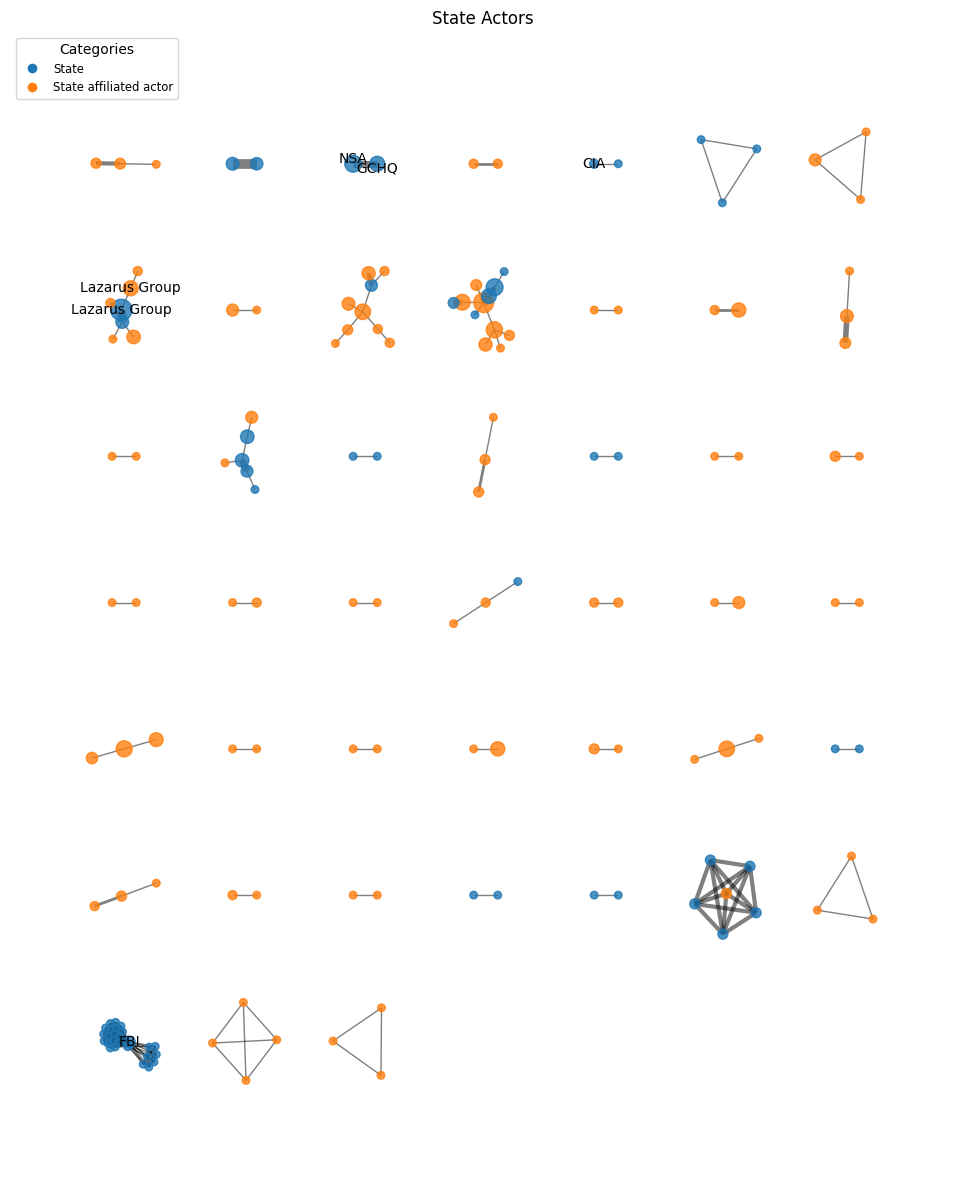

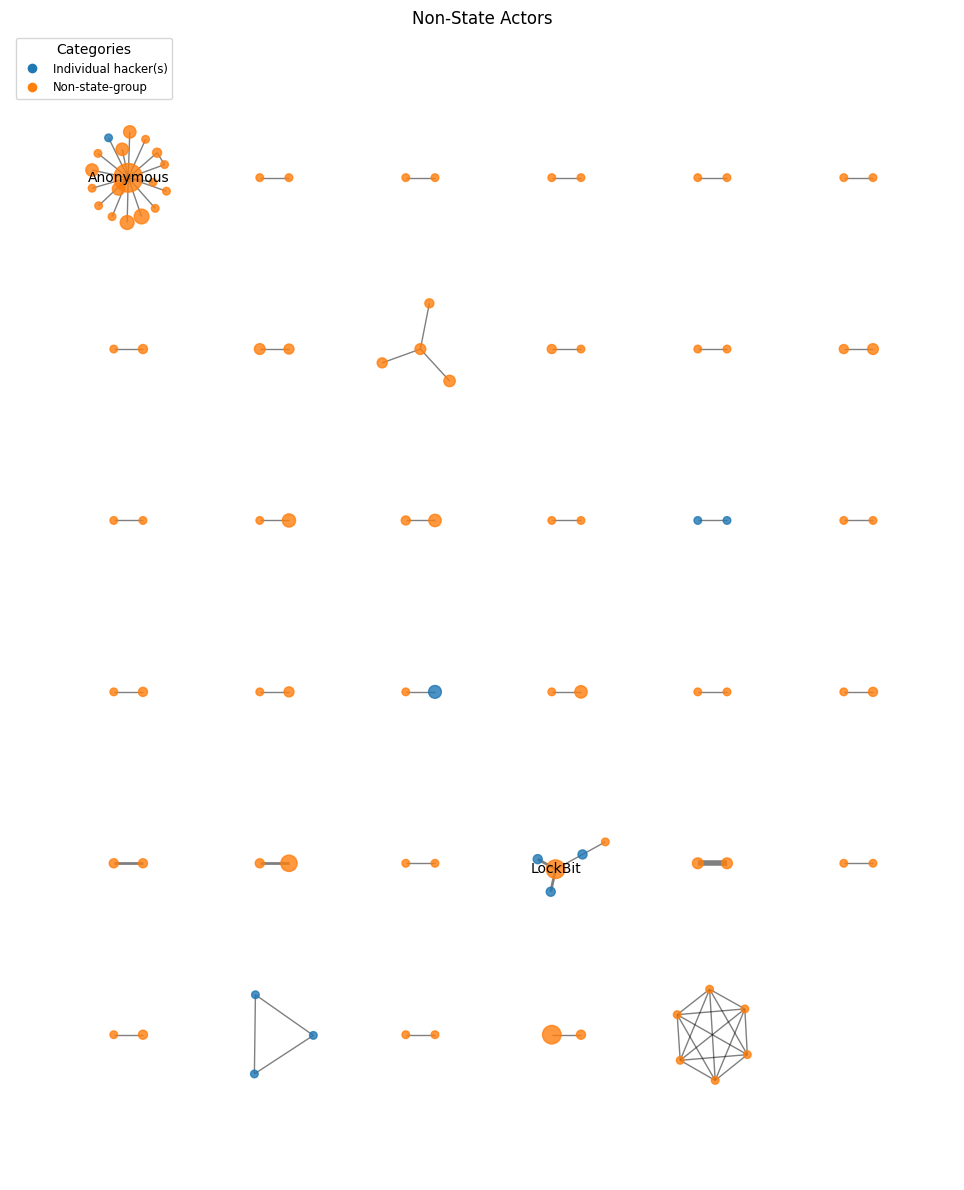

In [13]:
state_fig, state_axs = plot_actor_network(state_network, color_by='category', enable_labels = True)
non_state_fig, non_state_axs = plot_actor_network(non_state_network, color_by="category", enable_labels = True)


In [14]:
# Save the figures
state_fig.savefig('figures/state_actor_network.png', bbox_inches='tight', dpi=300)
non_state_fig.savefig('figures/non_state_actor_network.png', bbox_inches='tight', dpi=300)

# Use pillow to create a combined image
from PIL import Image
# Open the two images
state_img = Image.open('figures/state_actor_network.png')
non_state_img = Image.open('figures/non_state_actor_network.png')

# Create a new image with double the width of one image and the same height
combined_width = state_img.width + non_state_img.width
combined_height = max(state_img.height, non_state_img.height)
combined_img = Image.new('RGB', (combined_width, combined_height), (255, 255, 255))
# Paste the two images side by side
combined_img.paste(state_img, (0, 0))
combined_img.paste(non_state_img, (state_img.width, 0))
# Save the combined image
combined_img.save('figures/combined_actor_network.png')

(<Figure size 1200x1200 with 1 Axes>,
 <Axes: title={'center': 'Complete Network'}>)

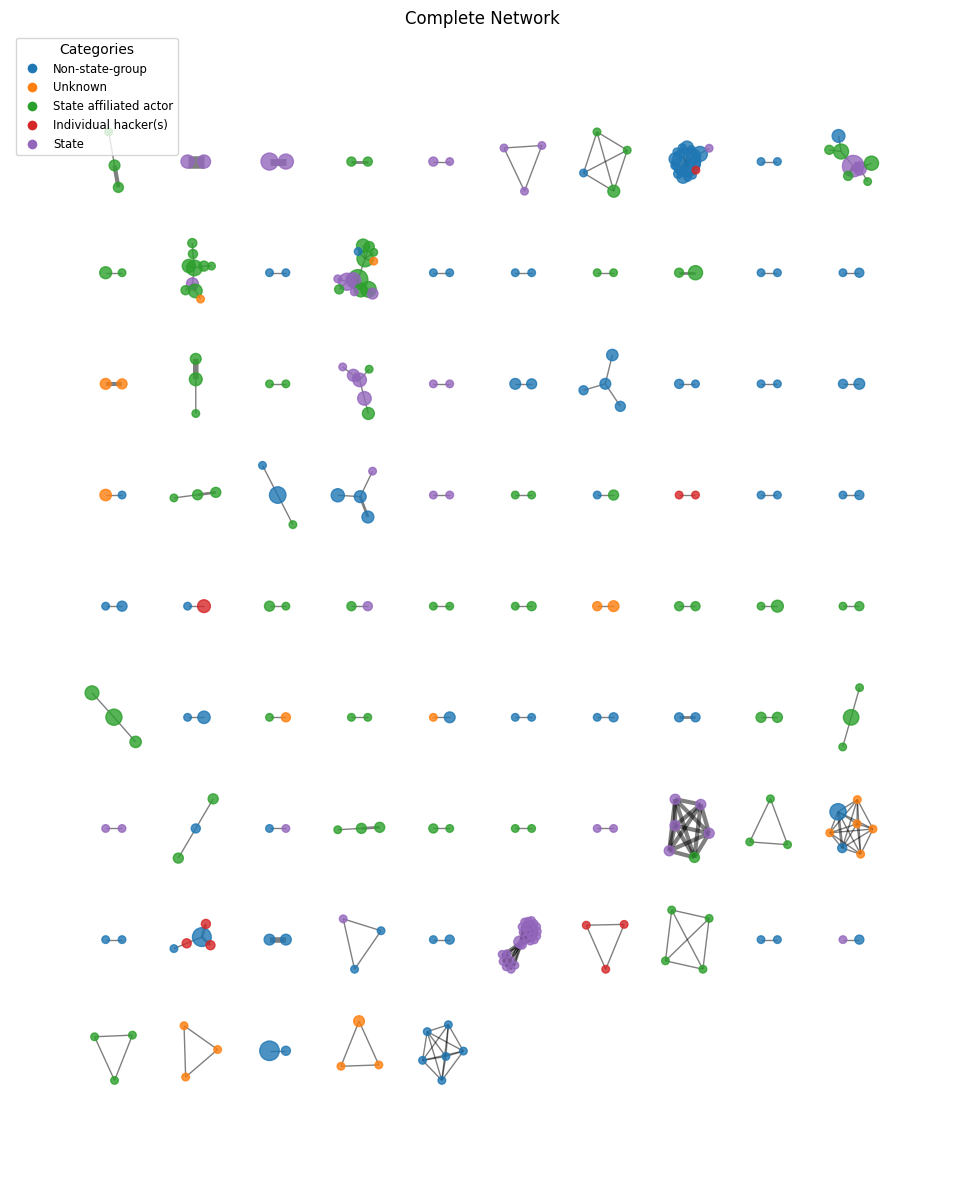

In [15]:
complete_network = create_actor_network(filtered_attributions, "Complete Network")
# plot_actor_network(complete_network, color_by='country')
plot_actor_network(complete_network, color_by='category', enable_labels=False)

In [16]:
"""
Print statistics for both networks
Nodes
Edges
Density
Components
Dyads
Dyads Fraction (as percentage)
Components with more than 2 nodes (large components)
Avg Freeman's Centralization
Avg component transitivity
Global clustering coefficient
Isolated actors
Isolated actors fraction (as percentage)
"""

def get_network_metrics(network: ActorNetwork):
    return pd.DataFrame([{
            "Network": network.name,
            "Nodes/Threat actors": network.n_nodes,
            "Edges": network.n_edges,
            "Density": round(network.density, 2),
            "Components": network.n_components,
            "Dyads": network.n_dyads,
            "Dyads ratio (%)": round(network.fraq_dyads * 100, 2),
            "Components with more than 2 nodes": network.n_large_components,
            "Avg. Freeman's Centralization": round(network.mean_freeman_centralization, 2),
            "Avg. Component Transitivity": round(network.mean_transitivity, 2),
            "Global Clustering Coefficient": round(network.global_clustering, 2),
            "Isolated Actors": network.n_isolated_actors,
            "Isolated ratio (%)": round(network.fraq_isolated_actors * 100, 2)
        }])

state_metrics = get_network_metrics(state_network)
non_state_metrics = get_network_metrics(non_state_network)
complete_metrics = get_network_metrics(complete_network)

# Combine metrics into a single DataFrame
metrics_df = pd.concat([complete_metrics, state_metrics, non_state_metrics], ignore_index=True)

metrics_df.T

,0,1,2
Network,Complete Network,State Actors,Non-State Actors
Nodes/Threat actors,281,157,96
Edges,427,311,73
Density,0.01,0.03,0.02
Components,85,45,35
Dyads,56,27,30
Dyads ratio (%),65.88,60.0,85.71
Components with more than 2 nodes,29,18,5
Avg. Freeman's Centralization,0.17,0.21,0.11
Avg. Component Transitivity,0.45,0.39,0.4


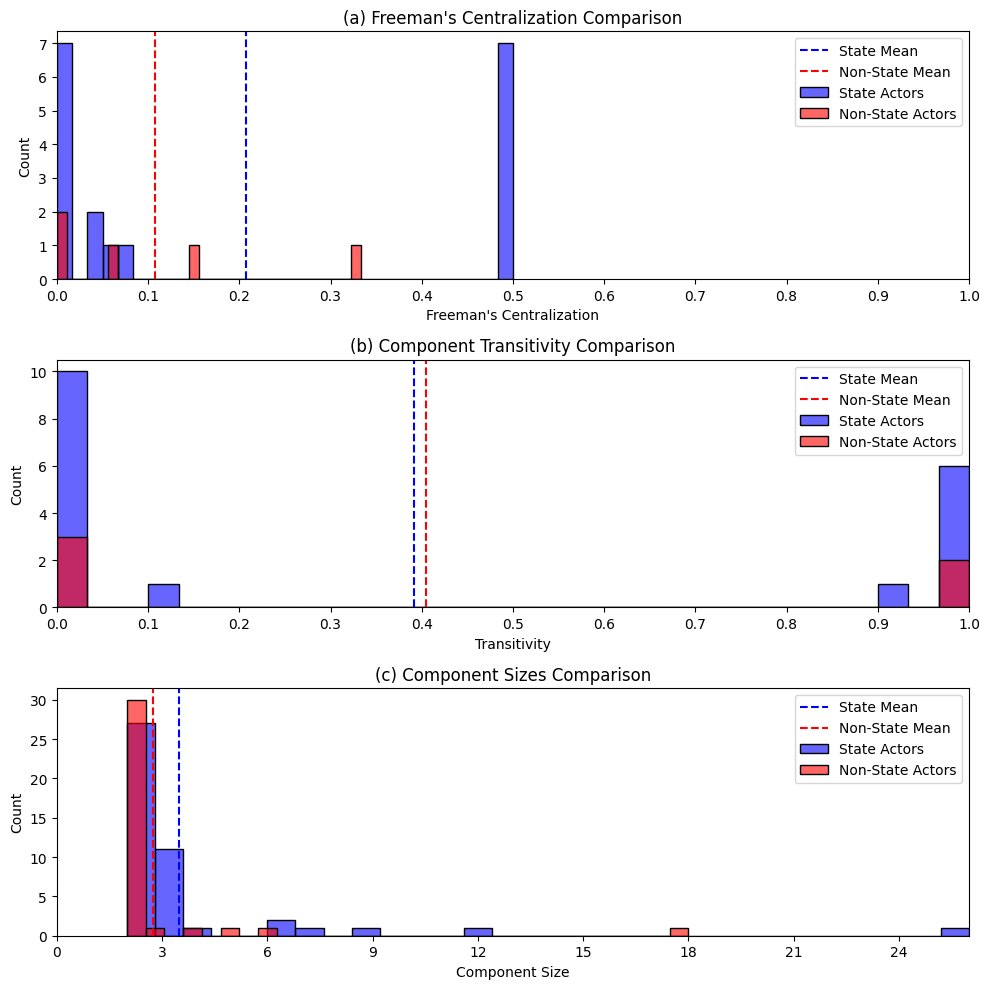

In [17]:
n_bins = 30

fig, axes = plt.subplots(3, 1, figsize=(10, 10))

# Freeman's Centralization
sns.histplot(state_network.freeman_centralization_per_component, bins=n_bins, ax=axes[0], 
			 color='blue', alpha=0.6, label="State Actors")
sns.histplot(non_state_network.freeman_centralization_per_component, bins=n_bins, ax=axes[0], 
			 color='red', alpha=0.6, label="Non-State Actors")
axes[0].set_title("(a) Freeman's Centralization Comparison")
axes[0].axvline(np.mean(state_network.freeman_centralization_per_component), color='blue', linestyle='--', label='State Mean')
axes[0].axvline(np.mean(non_state_network.freeman_centralization_per_component), color='red', linestyle='--', label='Non-State Mean')
axes[0].set_xlim(0, 1)
axes[0].set_xlabel("Freeman's Centralization")
axes[0].xaxis.set_ticks(np.arange(0, 1.1, 0.1))
axes[0].legend()

# Component Transitivity
sns.histplot(state_network.transitivity_per_component, bins=n_bins, ax=axes[1], 
			 color='blue', alpha=0.6, label="State Actors")
sns.histplot(non_state_network.transitivity_per_component, bins=n_bins, ax=axes[1], 
			 color='red', alpha=0.6, label="Non-State Actors")
axes[1].set_title("(b) Component Transitivity Comparison")
axes[1].axvline(np.mean(state_network.transitivity_per_component), color='blue', linestyle='--', label='State Mean')
axes[1].axvline(np.mean(non_state_network.transitivity_per_component), color='red', linestyle='--', label='Non-State Mean')
axes[1].set_xlim(0, 1)
axes[1].set_xlabel("Transitivity")
axes[1].xaxis.set_ticks(np.arange(0, 1.1, 0.1))
axes[1].legend()

# Component Sizes
sns.histplot(state_network.component_sizes, bins=n_bins, ax=axes[2], 
			 color='blue', alpha=0.6, label="State Actors")
sns.histplot(non_state_network.component_sizes, bins=n_bins, ax=axes[2], 
			 color='red', alpha=0.6, label="Non-State Actors")
axes[2].set_title("(c) Component Sizes Comparison")
axes[2].axvline(np.mean(state_network.component_sizes), color='blue', linestyle='--', label='State Mean')
axes[2].axvline(np.mean(non_state_network.component_sizes), color='red', linestyle='--', label='Non-State Mean')
axes[2].set_xlim(0, 26)
axes[2].set_xlabel("Component Size")
axes[2].xaxis.set_ticks(np.arange(0, 27, 3))
axes[2].legend()

plt.tight_layout()

In [19]:
# Calculate the sd of each distribution
# Freeman's Centralization
state_freeman_sd = np.std(state_network.freeman_centralization_per_component)
non_state_freeman_sd = np.std(non_state_network.freeman_centralization_per_component)

# Component Transitivity
state_transitivity_sd = np.std(state_network.transitivity_per_component)
non_state_transitivity_sd = np.std(non_state_network.transitivity_per_component)

# Component Sizes
state_component_size_sd = np.std(state_network.component_sizes)
non_state_component_size_sd = np.std(non_state_network.component_sizes)

print(f"State Actors Freeman's Centralization SD: {state_freeman_sd:.2f}, Mean: {np.mean(state_network.freeman_centralization_per_component):.2f}")
print(f"Non-State Actors Freeman's Centralization SD: {non_state_freeman_sd:.2f}, Mean: {np.mean(non_state_network.freeman_centralization_per_component):.2f}")
print(f"State Actors Component Transitivity SD: {state_transitivity_sd:.2f}, Mean: {np.mean(state_network.transitivity_per_component):.2f}")
print(f"Non-State Actors Component Transitivity SD: {non_state_transitivity_sd:.2f}, Mean: {np.mean(non_state_network.transitivity_per_component):.2f}")
print(f"State Actors Component Size SD: {state_component_size_sd:.2f}, Mean: {np.mean(state_network.component_sizes):.2f}")
print(f"Non-State Actors Component Size SD: {non_state_component_size_sd:.2f}, Mean: {np.mean(non_state_network.component_sizes):.2f}")

State Actors Freeman's Centralization SD: 0.23, Mean: 0.21
Non-State Actors Freeman's Centralization SD: 0.12, Mean: 0.11
State Actors Component Transitivity SD: 0.48, Mean: 0.39
Non-State Actors Component Transitivity SD: 0.49, Mean: 0.40
State Actors Component Size SD: 3.94, Mean: 3.49
Non-State Actors Component Size SD: 2.76, Mean: 2.74
